# Gesture Based Calculator
Hello and welcome everyone to our last project on the #7DaysOfComputerVisionProjects series where we did some cool computer vision projects using image processing and opensource tools. Here in this project, we will build a calculator and we will control it by moving our fingers in front of the camera. We will make a simple UI for selecting operators like +, -, * and so on. The calculator will be very basic one so lets get into the first part.

## Preliminary Actions
### Imports and dummy show function
* Mediapipe will be used for  land landmarks extraction.
* OpeCv for image operations.
* Numpy for array operations.
* Matplotlib for showing images.
* Counter for getting the counts of value in dictionary format.

I always use the below function whenever I am working with image. This function will show our image into larger figure than default matplotlib figure.

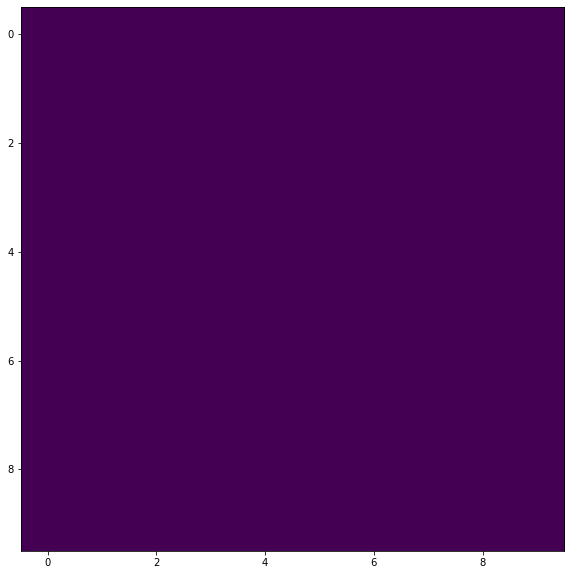

In [2]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def show(img, fsize=(10, 10)):
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()
    
show(np.zeros((10, 10)))

## Function to find Euclidean distance

In [3]:
def euclidean(pt1, pt2):
    d = np.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)
    return d
euclidean((4, 3), (0, 0))

5.0

## Make Calculator

* Just like previous projects with mediapipe, start the camera source, frame size, show_ever and check count.
```python
cam = cv2.VideoCapture(0)
fsize = (600, 820)

show_every = 15
check_cnt = 0
```
* Define a list of operators that we are going to operate in. We will do sum, subtract, divide, multiply, clear and equals.
```python
operators = ["+", "-", "/", "*", "C", "="]
ops = len(operators)
```
* Define columns Define an array where our operators will be residing on. In it, we will visualize our operators as text. Define an array where we will visualize our operators.
```python
cols = np.linspace(0, fsize[1]-1, ops+1).astype(np.int64)
cols = [(cols[i], cols[i+1]) for i in range(len(cols)-1)]
opd = np.zeros((100, fsize[1], 3), dtype="uint8")
```
* We will make 2 ROIs for getting numbers. One will be in right and another in left. So define left, top, right and bottom values for both sides.
```python
l1,t1,r1,b1=(50, 200, 350, 500)
l2,t2,r2,b2=(500, 200, 800, 500)
```
* Now, put the operator on previously created array. Use the columns (and its border) that we defined earlier and highlight columns by giving RGB 200, 200, 200 to make it look like that a rectangle is around the operator.
```python
for i, col in enumerate(cols):
    opd[:, 0:2] =[200, 200, 200]
    
    opd[:, col[0]-2:col[0]+2] = [200, 200, 200]
    opd[:, col[1]-2:col[1]+2] = [200, 200, 200]
    cv2.putText(opd, operators[i], (int((col[0]+col[1])/2), 60), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 3)

```
* Take hands and drawing modules from mediapipe soulutions.
```python
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
```
* Define a variable, equation where we will store all the numbers, operators in string format.
```python
eqtn = ""
```
* Define a list `values` for storing all the predicted values. Define a variable `pred` for storing predicted value, define a list `itips` for storing index tip positions. Define a variable `op` for storing current operator. Define a variable `output` for storing output.
```python
values = []
pred=0
itips = []
op=None
output = None
```
* Take a hand module and detect maximum of 2 hands.
```python
with mp_hands.Hands(static_image_mode = True,
                   max_num_hands=2,
                   min_detection_confidence=0.2) as hands:
```
* If camera is open, read the frame. And if not successful, skip the pass.
```python
    while cam.isOpened():
        ret, frame = cam.read()
        if not ret:
            continue
```
* Wait for the key press.
```python
        key = cv2.waitKey(1)&0xFF
 ```
 * Define the buffer as 0. It will hold the predicted number in this frame. Flip the frame to make it like selfie image, resize it to predefined shape.
```python
        buffer = 0
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, fsize[::-1])
```        
* Convert frame to RGB and pass it to process of hands module.
```python
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
```
* Define a variable just to check the distance between tip and pip of each finger. The purpose of this value will be to check if the finger is folded or not.
```python
        fv=10
```
* Make rectangle for ROIs in both left and right side.
```python
        cv2.rectangle(frame, (l1, t1), (r1, b1), (0, 0, 255), 1)        
        cv2.rectangle(frame, (l2, t2), (r2, b2), (0, 0, 255), 1)
```
* Take height and width of frame. we will use this to convert landmark positions to frame world.
```python
        h, w = frame.shape[:-1]
``` 
* Define a list, index tip as the impossible value just for beginning. Define a dictionary to hold counts of fingers in each hand. Define a variable to see if current mode is move or not.
```python
        index_tip=[-1,-1]
        fcounts = {}
        move = False
```
* If hand landmarks has been detected, then loop through them.
```python
        if res.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(res.multi_hand_landmarks):
```
* Define a new variable bv, which will be counting the buffer variable. Its purpose is to count number of finger ups on this hand. Draw landmarks in frame.
```python
                bv = 0
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
```
* Take index finger tip, index finger pip, middle finger tip, middle finger pip, ring finger tip, ring finger pip, pinky finger tip, pinky finger pip, thumb finger tip, thumbg finger ip and wrist landmarks. Convert them all into frame world too.
```python
                index_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y,
                    w, h)
                index_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y,
                    w, h)
                
                middle_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y,
                    w, h)
                middle_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].y,
                    w, h)
                
                ring_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y,
                    w, h)
                ring_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].y,
                    w, h)
                
                pinky_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y,
                    w, h)
                pinky_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].y,
                    w, h)
                
                thumb_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y,
                    w, h)
                thumb_ip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].y,
                    w, h)
                
                wrist = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y,
                    w, h)
```
* If index tip and pip is not none then we will check few things. First, if index tip is on top side i.e. below 100 rows, then we assume that our finger is on the top part so we will check for the operators. Our operators panel will be on the top. There are predefined columns for each operator and we will check that where does our pointer lies and we did it in some kind of list comprehension. If we actually found where is our pointer now, then we will take the index of it because, we will be showing operators in same order as in `operators` list and panel. We will take the operator with the found index. If the difference between index tip and index pip's row is smaller than `fv` i.e finger value then we will increase the buffer. In the normal hand mode, i.e. not while folding fingers, the value will be always -ve. 
```python
                if index_pip is not None and index_tip is not None:
                    if index_tip[1]<100:
                        itp = [v for v in cols if index_tip[0]>v[0] and index_tip[0]<v[1]]
                        if len(itp)>0:
                            itp = cols.index(itp[0])
                            op = operators[itp]
                    if index_tip[1]-index_pip[1]<fv:
                            bv+=1
```
* If middle tip and pip is not none and their row's difference is smaller than fv, we will increase the buffer. Because if the finger is up, the difference will be -ve and if it is folded, it will be near 0 or even positive. Do similar for ring finger, pinky finger, and thumb.
```python                
                if middle_pip is not None and middle_tip is not None:
                    if middle_tip[1]-middle_pip[1]<fv:
                            bv+=1
                
                if ring_pip is not None and ring_tip is not None:
                    if ring_tip[1]-ring_pip[1]<fv:
                            bv+=1
                                
                if pinky_pip is not None and pinky_tip is not None:
                    if pinky_tip[1]-pinky_pip[1]<fv:
                            bv+=1

                if thumb_tip is not None and index_pip is not None:
                    if euclidean(index_pip, thumb_tip)>60:
                            bv+=1
```
* Now put the bv or buffer value to fcounts.
```python
                fcounts[i] = bv
```
* But we want that buffer value to be accepted only if our wrist is on the bottom half of the ROI rectangle. So Check for writst and its position. If the wrist is above half, just cancel out the buffer.
```python
                if wrist is not None:
                    if b1>wrist[1] and (t1+b1)/2<wrist[1]:
                        #pass
                    elif b2>wrist[1] and (t2+b2)/2<wrist[1]:
                        #pass
                    else:
                        fcounts[i] = 0
```      
* For the move mode and count mode, we will define a rule that if the distance between thumb tip and index pip is near zero then we will conclude that we are only moving cursor but not counting the fingers. But if the distance is above or equal to 60, we will append the value of buffer into values list.
```python
            if index_pip is not None and thumb_tip is not None:                
                
                #print(euclidean(index_pip, thumb_tip))
                if euclidean(index_pip, thumb_tip)<60:
                    move = True
```
* Sum the values in fcounts. And if move is False then we will append the buffer value to values because it is count mode else, we will cancel out buffer.
```python
        buffer = sum(list(fcounts.values()))
        if move:
            buffer = 0
        else:
            values.append(buffer)
```
* If check count is greater than show every value then we will check for the operation or predicted number or counts of finger up. Then make check count a 0.
```python
        if show_every<check_cnt:
            check_cnt=0
```
* If the list values have more than 1 items and the buffer is not 0 then we will find the possible predicted number by geting the value which occured most. When the buffer is 0, there  wont be any finger ups.
```python
            if len(values)>1 and buffer!=0:
                d = dict(Counter(values))
                pred = sorted(d.items(), key=lambda x: x[1], reverse=True)[0][0]
```
* If output is not none, then we we will make it none and equation to default. Because output usually needs to be none on start.
```python
                if output is not None:
                    output=None
                    eqtn=""
```
* We will add the predicted number in string format to equation.
```python
                eqtn+=str(pred)
```
* If prediction is not 0, then we will show the predicted number on the screen.
```python
            if pred != 0:
                cv2.putText(frame, str(pred), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (200, 100, 200), 3)
```
* If operator is not none and operator is not `C` i.e clear then we will perform the equation if equation is present and operator is `=`. We will also check for repeatation of operators and we will not repeat them. If last operator is not `=`then we will add that operator to our equation. But if the output is not none and then which means, the current operator will be doing opeartion with last output and we will make it happen by starting new equation by giving output. Please look at the comments too.
```python
            if op is not None and op != "C": # check if operator is not clear and not none
                if len(eqtn)>0: # if the equation is not only then the purpose of operator is taken
                    # if last operator is not equal to current operator this is necessary 
                    # if finger lies multiple times on same operator position 
                    # but it might fail when equation becomes something like : 4*/4
                    if eqtn[-1]!=op:
                        if eqtn[-1] in operators: # if last item of eqtn is operator then we should replace it with current
                            eqtn = eqtn[:-1] # but first remove that operator
                        if op=="=": # if operator is `=` then we will calculate the equation but use try except block
                            try: # not all equation can be solvable so use try except
                                output=eval(eqtn) # try to evaluate equation and get result in string format
                                eqtn=str(output) 
                                print(f"Output: {output}") # show the output
                            except:
                                print(f"Error: {eqtn}") # if not solvable, show error
                        else:
                            if output is not None: # if output is not none, i.e. we have the output of prev. eqtn 
                                eqtn=str(output) # take that output as new item in equation
                                output=None
                            eqtn+=op # and append that operand on the back of equation
                            
                        op=None
```
* If operator is `C` i.e. clear then we will make output None, clear the equation and values.
```python
            if op == "C":
                output=None
                eqtn=""
                values=[]
```
* Finally, we will reset the values like operator, buffer, prediction and values on every show frames.
```python
            op=None
            buffer=0
            pred=0
            values=[]
```
* Furthermore, show the output if it is real value. Show the equation on frame too.
```python
        if output is not None:
                cv2.putText(frame, str(output), (80, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (200, 100, 100), 3)
        cv2.putText(frame, str(eqtn), (200, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (200, 100, 200), 3)
```
* Show the operator panel on frame by simply replacing 0 to 100 columns of frame by operator details.
```python
        frame[0:100] = opd
```
* Draw a circle on frame at the index tip. It will represent something like a cursor. And reason for adding circle at last is that we want it to be visible on operators panel too. Show the frame. If the key was escape then end the loop else keep increasing check count by 1. At last, release the camera and destroy all windows.
```python
        cv2.circle(frame, index_tip, 10, (0, 0, 255), -1)
        cv2.imshow("Frame", frame)
        if key==27:
            break
        
        check_cnt+=1
cam.release()
cv2.destroyAllWindows()
```


## Full Code

In [8]:
cam = cv2.VideoCapture(0)
fsize = (600, 820)


show_every = 15
check_cnt = 0

operators = ["+", "-", "/", "*", "C", "="]
ops = len(operators)
opd = np.zeros((100, fsize[1], 3), dtype="uint8")

cols = np.linspace(0, fsize[1]-1, ops+1).astype(np.int64)
cols = [(cols[i], cols[i+1]) for i in range(len(cols)-1)]
opd = np.zeros((100, fsize[1], 3), dtype="uint8")

l1,t1,r1,b1=(50, 200, 350, 500)
l2,t2,r2,b2=(500, 200, 800, 500)

for i, col in enumerate(cols):
    opd[:, 0:2] =[200, 200, 200]
    
    opd[:, col[0]-2:col[0]+2] = [200, 200, 200]
    opd[:, col[1]-2:col[1]+2] = [200, 200, 200]
    cv2.putText(opd, operators[i], (int((col[0]+col[1])/2), 60), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 3)



mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


eqtn = ""

values = []
pred=0
itips = []
op=None
output = None

with mp_hands.Hands(static_image_mode = True,
                   max_num_hands=2,
                   min_detection_confidence=0.2) as hands:
    while cam.isOpened():
        ret, frame = cam.read()
        
        key = cv2.waitKey(1)&0xFF
        if not ret:
            continue
        
        
        buffer = 0
        
        
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, fsize[::-1])
        
        
        
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
        
        fv=10
        
        
        cv2.rectangle(frame, (l1, t1), (r1, b1), (0, 0, 255), 1)        
        cv2.rectangle(frame, (l2, t2), (r2, b2), (0, 0, 255), 1)
        
        
        h, w = frame.shape[:-1]
        index_tip=[-1,-1]
        
        fcounts = {}
        move = False
        
        if res.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(res.multi_hand_landmarks):
                bv = 0
                
                
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                index_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y,
                    w, h)
                index_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y,
                    w, h)
                
                middle_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y,
                    w, h)
                middle_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].y,
                    w, h)
                
                ring_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y,
                    w, h)
                ring_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].y,
                    w, h)
                
                pinky_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y,
                    w, h)
                pinky_pip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].y,
                    w, h)
                
                thumb_tip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y,
                    w, h)
                thumb_ip = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].y,
                    w, h)
                
                wrist = mp_drawing._normalized_to_pixel_coordinates(
                    hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x,
                    hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y,
                    w, h)
                
                if index_pip is not None and index_tip is not None:
                    if index_tip[1]<100:
                        itp = [v for v in cols if index_tip[0]>v[0] and index_tip[0]<v[1]]
                        if len(itp)>0:
                            itp = cols.index(itp[0])
                            op = operators[itp]
                    if index_tip[1]-index_pip[1]<fv:
                        bv+=1
                
                
                if middle_pip is not None and middle_tip is not None:
                    if middle_tip[1]-middle_pip[1]<fv:
                        bv+=1
                
                if ring_pip is not None and ring_tip is not None:
                    if ring_tip[1]-ring_pip[1]<fv:
                        bv+=1
                                
                if pinky_pip is not None and pinky_tip is not None:
                    if pinky_tip[1]-pinky_pip[1]<fv:
                        bv+=1

                if thumb_tip is not None and index_pip is not None:
                    if euclidean(index_pip, thumb_tip)>60:
                        bv+=1
                
                fcounts[i] = bv
                if wrist is not None:
                    if b1>wrist[1] and (t1+b1)/2<wrist[1]:
                        pass
                    elif b2>wrist[1] and (t2+b2)/2<wrist[1]:
                        pass
                    else:
                        fcounts[i] = 0
                
                if index_pip is not None and thumb_tip is not None:
                    if euclidean(index_pip, thumb_tip)<60:
                        move = True
        
        buffer = sum(list(fcounts.values()))
        
        if move:
            buffer = 0
        else:
            values.append(buffer)
        
        if show_every<check_cnt:
            check_cnt=0
            if len(values)>1 and buffer!=0:
                d = dict(Counter(values))
                pred = sorted(d.items(), key=lambda x: x[1], reverse=True)[0][0]
                
                if output is not None:
                    output=None
                    eqtn=""
                #pred = sorted(values)[-1]
                eqtn+=str(pred)
            if pred != 0:
                cv2.putText(frame, str(pred), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (200, 100, 200), 3)
            if op is not None and op != "C":
                if len(eqtn)>0:
                    if eqtn[-1]!=op:
                        
                        if eqtn[-1] in operators:
                            eqtn = eqtn[:-1]
                        if op=="=":
                            try:
                                output=eval(eqtn)
                                print(f"Output: {output}")
                                eqtn=str(output)
                            except:
                                print(f"Error in equation: {eqtn}")
                        else:
                            if output is not None:
                                eqtn=str(output)
                                output=None
                            eqtn+=op
                            
                        op=None
            if op == "C":
                output=None
                eqtn=""
                values=[]
            
            op=None
            buffer=0
            pred=0
            values=[]
        if output is not None:
            cv2.putText(frame, str(output), (80, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (200, 100, 100), 3)
        cv2.putText(frame, str(eqtn), (200, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (200, 100, 200), 3)
        
        frame[0:100] = opd
        cv2.circle(frame, index_tip, 10, (0, 0, 255), -1)
        cv2.imshow("Frame", frame)
        if key==27:
            break
        
        check_cnt+=1
cam.release()
cv2.destroyAllWindows()
        

Output: 555555555550
Output: 555555555550


## Finally
There are few things I might have did wrong and there always can be logical error so please feel free to reach out to us and leave comments.

Thank you for reading this blog and getting till the end part and I would like to encourage you to view video on YouTube too. The links to our repository and YouTube video are below:
* [YouTube]()
* [GitHub]()
